# YouTube Data API Project

This script collects data from a specific YouTube channel using the YouTube Data API v3.
It retrieves channel statistics, video details (like view count, likes, etc.), and performs
various analyses on the collected data.

## Step-by-Step Approach

1. Set up API credentials and required libraries:
   - Import necessary libraries: googleapiclient for API interaction, dateutil for date parsing,
     pandas for data manipulation, seaborn and matplotlib for visualization.

2. Define API key and channel ID:
   - `api_key` stores the API key required for accessing the YouTube Data API.
   - `channel_ids` lists the IDs of YouTube channels from which data will be collected.

3. Import required packages:
   - Imported packages include libraries for API interaction (build from googleapiclient.discovery),
     date parsing (parser from dateutil), pandas for data handling, and JSON for displaying API responses.

4. Build the YouTube API client:
   - Use the `build` function from googleapiclient.discovery to create a client for interacting with
     the YouTube Data API using the specified `api_key`.

5. Define functions for data collection:
   - `get_channel_stats(youtube, channel_ids)`: Retrieves channel statistics including subscriber count,
     total views, and total videos.
   - `get_video_ids(youtube, playlist_id)`: Retrieves video IDs from the specified playlist.
   - `get_video_details(youtube, video_ids)`: Retrieves detailed statistics for each video, including
     view count, likes, duration, etc.

6. Data collection:
   - Retrieve channel statistics using `get_channel_stats`.
   - Retrieve video IDs from the channel's playlist using `get_video_ids`.
   - Retrieve detailed video statistics using `get_video_details`.

7. Data cleaning and preprocessing:
   - Convert data types, handle missing values, parse dates, and compute additional metrics like duration
     in seconds (`durationSecs`) and tag count (`tagCount`).

8. Data visualization and analysis:
   - Visualize top videos by view count using bar plots (`sns.barplot`).
   - Analyze relationships between variables (like views vs. likes, views vs. comments) using scatter plots
     (`sns.scatterplot`).
   - Explore distribution of video durations using a histogram (`sns.histplot`).

9. Conclusion:
   - Summarize findings and insights from the data analysis.

In [2]:
api_key = "<YOUR_API_KEY>"

In [3]:
channel_ids = ['UCoOae5nYA7VqaXzerajD0lg']

## Data collection

In [25]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON 

In [27]:
# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [26]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client

youtube = build(api_service_name, api_version, developerKey=api_key)

In [6]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [7]:
playlist_id = "UUoOae5nYA7VqaXzerajD0lg"

In [8]:
def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [9]:
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
def get_video_details(youtube, video_ids):
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }

            video_info = {}
            video_info['video_id'] = video['id']

            # print(video_info)
            # print(stats_to_keep.keys())

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [11]:
video_df = get_video_details(youtube, video_ids)

## Data Pre-processing

In [12]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [13]:
video_df.dtypes


video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [14]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']

In [15]:
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [16]:
video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount           int64
likeCount           int64
favouriteCount    float64
commentCount        int64
duration           object
definition         object
caption            object
dtype: object

In [17]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [18]:
video_df


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName
0,eBVlVfAMtWc,Ali Abdaal,My honest advice to someone who’s doing too much,Head over to Brilliant for a 30 day free trial...,"[Ali Abdaal, Ali abdal]",2024-07-12 13:00:43+00:00,21258,1305,NaN,194,PT23M3S,hd,false,Friday
1,wD9hMYbijDA,Ali Abdaal,"If I Wanted to Make $10,000 as a Student, I'd ...",Use the promo code ALI to get a free share wor...,"[Ali Abdaal, Ali abdal, high income skills, ho...",2024-07-09 13:01:05+00:00,136430,6264,NaN,324,PT14M34S,hd,false,Tuesday
2,jAPPP7SE824,Ali Abdaal,Level Up as If You Were in a Video Game 🎮,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-09 12:00:52+00:00,12159,984,NaN,108,PT47S,hd,false,Tuesday
3,HKGAzzqkfWM,Ali Abdaal,The Thing That Made Me More Productive ⚡️,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-08 12:00:13+00:00,19086,1119,NaN,48,PT38S,hd,false,Monday
4,lrZQz2O91JY,Ali Abdaal,What I Learned on My Personal Finance Journey 💰,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-07 12:00:57+00:00,18370,1530,NaN,120,PT52S,hd,false,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,96512,2327,NaN,150,PT2M35S,hd,false,Wednesday
965,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,17382,132,NaN,6,PT2M11S,hd,false,Monday
966,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,42417,305,NaN,10,PT2M18S,hd,false,Wednesday
967,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,65957,793,NaN,40,PT2M29S,hd,false,Tuesday


In [21]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs
0,eBVlVfAMtWc,Ali Abdaal,My honest advice to someone who’s doing too much,Head over to Brilliant for a 30 day free trial...,"[Ali Abdaal, Ali abdal]",2024-07-12 13:00:43+00:00,21258,1305,NaN,194,PT23M3S,hd,false,Friday,0 days 00:23:03
1,wD9hMYbijDA,Ali Abdaal,"If I Wanted to Make $10,000 as a Student, I'd ...",Use the promo code ALI to get a free share wor...,"[Ali Abdaal, Ali abdal, high income skills, ho...",2024-07-09 13:01:05+00:00,136430,6264,NaN,324,PT14M34S,hd,false,Tuesday,0 days 00:14:34
2,jAPPP7SE824,Ali Abdaal,Level Up as If You Were in a Video Game 🎮,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-09 12:00:52+00:00,12159,984,NaN,108,PT47S,hd,false,Tuesday,0 days 00:00:47
3,HKGAzzqkfWM,Ali Abdaal,The Thing That Made Me More Productive ⚡️,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-08 12:00:13+00:00,19086,1119,NaN,48,PT38S,hd,false,Monday,0 days 00:00:38
4,lrZQz2O91JY,Ali Abdaal,What I Learned on My Personal Finance Journey 💰,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-07 12:00:57+00:00,18370,1530,NaN,120,PT52S,hd,false,Sunday,0 days 00:00:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,96512,2327,NaN,150,PT2M35S,hd,false,Wednesday,0 days 00:02:35
965,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,17382,132,NaN,6,PT2M11S,hd,false,Monday,0 days 00:02:11
966,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,42417,305,NaN,10,PT2M18S,hd,false,Wednesday,0 days 00:02:18
967,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,65957,793,NaN,40,PT2M29S,hd,false,Tuesday,0 days 00:02:29


In [23]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [24]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,eBVlVfAMtWc,Ali Abdaal,My honest advice to someone who’s doing too much,Head over to Brilliant for a 30 day free trial...,"[Ali Abdaal, Ali abdal]",2024-07-12 13:00:43+00:00,21258,1305,NaN,194,PT23M3S,hd,false,Friday,0 days 00:23:03,2
1,wD9hMYbijDA,Ali Abdaal,"If I Wanted to Make $10,000 as a Student, I'd ...",Use the promo code ALI to get a free share wor...,"[Ali Abdaal, Ali abdal, high income skills, ho...",2024-07-09 13:01:05+00:00,136430,6264,NaN,324,PT14M34S,hd,false,Tuesday,0 days 00:14:34,19
2,jAPPP7SE824,Ali Abdaal,Level Up as If You Were in a Video Game 🎮,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-09 12:00:52+00:00,12159,984,NaN,108,PT47S,hd,false,Tuesday,0 days 00:00:47,2
3,HKGAzzqkfWM,Ali Abdaal,The Thing That Made Me More Productive ⚡️,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-08 12:00:13+00:00,19086,1119,NaN,48,PT38S,hd,false,Monday,0 days 00:00:38,2
4,lrZQz2O91JY,Ali Abdaal,What I Learned on My Personal Finance Journey 💰,Check out my New York Times bestselling book a...,"[Ali Abdaal, Ali abdal]",2024-07-07 12:00:57+00:00,18370,1530,NaN,120,PT52S,hd,false,Sunday,0 days 00:00:52,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,96512,2327,NaN,150,PT2M35S,hd,false,Wednesday,0 days 00:02:35,4
965,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,17382,132,NaN,6,PT2M11S,hd,false,Monday,0 days 00:02:11,4
966,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,42417,305,NaN,10,PT2M18S,hd,false,Wednesday,0 days 00:02:18,4
967,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,65957,793,NaN,40,PT2M29S,hd,false,Tuesday,0 days 00:02:29,4


## Analysis: Best performing videos

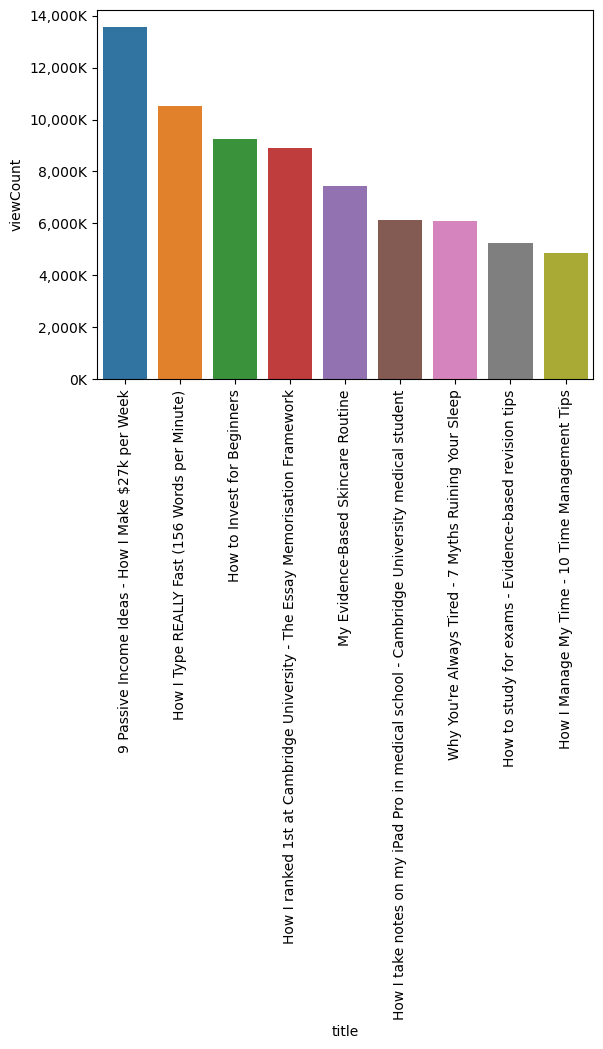

In [33]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

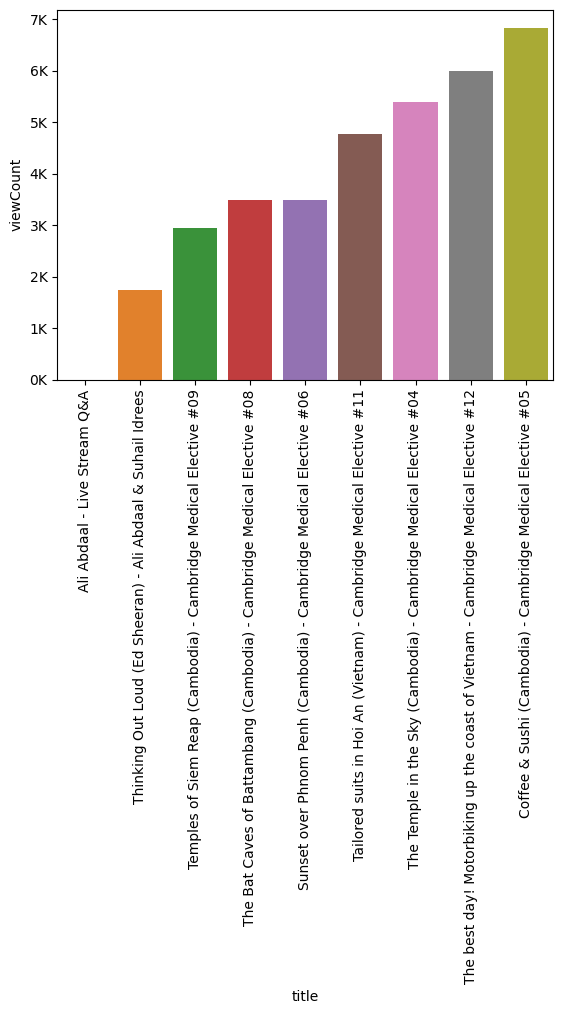

In [34]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video


<Axes: >

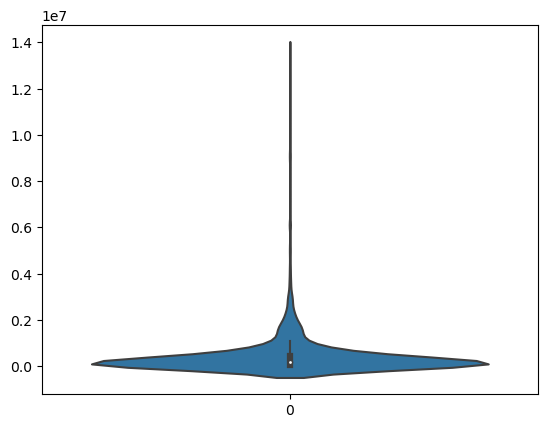

In [36]:
sns.violinplot(video_df['viewCount'])

## Views vs. likes and comments

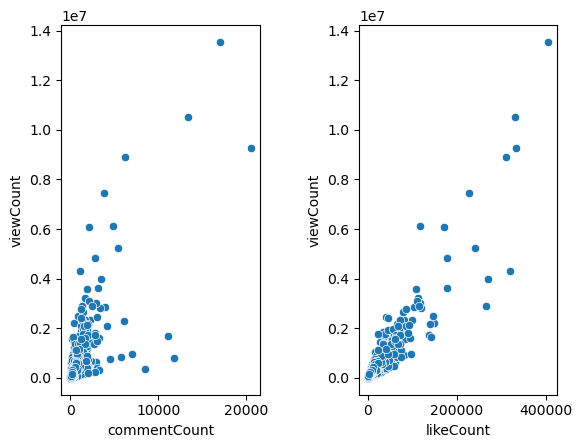

In [38]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])
plt.subplots_adjust(wspace=0.5)

## Video duration

C:\Users\anaum\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


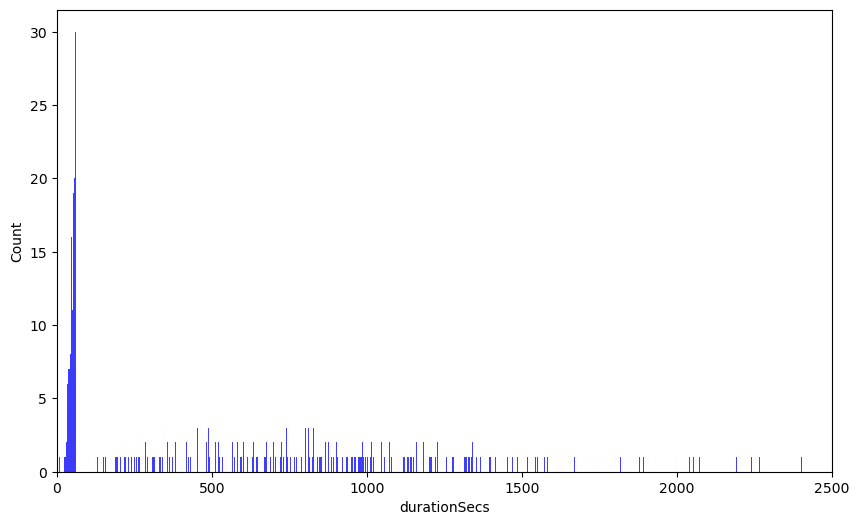

In [49]:
# Increase the figure size
plt.figure(figsize=(10, 6))  # Adjust figsize as per your preference

# Plot the histogram with adjusted bins and color
sns.histplot(data=video_df, x='durationSecs', bins=50, color='blue')

# Set the x-axis limit to zoom in on frequencies up to 2500
plt.xlim(0, 2500)


# Display the plot
plt.show()